In [111]:
### import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns

from sklearn.model_selection import train_test_split, ShuffleSplit, learning_curve, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.metrics import roc_curve, accuracy_score, confusion_matrix, classification_report, roc_auc_score, make_scorer, precision_recall_curve, average_precision_score 
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier, IsolationForest, VotingClassifier
from sklearn.neural_network import MLPClassifier

%matplotlib inline
plt.style.use('ggplot')

from catboost import CatBoostClassifier # Or CatBoostRegressor
from sklearn.model_selection import KFold
from paramsearch import paramsearch
from itertools import product,chain

import shap
import catboost
from catboost import *
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import recall_score, accuracy_score, confusion_matrix, classification_report

In [112]:
def read_data():
    target = pd.read_csv("./data/Train.csv")
    ben_data = pd.read_csv("./data/Train_Beneficiarydata.csv")
    in_pt_data = pd.read_csv("./data/Train_Inpatientdata.csv")
    out_pt_data = pd.read_csv("./data/Train_Outpatientdata.csv")
    return (in_pt_data, out_pt_data, ben_data, target)

In [113]:
def N_unique_values(df):
    return np.array([len(set([i for i in x[~pd.isnull(x)]])) for x in df.values])

## Explore datasets 

In [114]:
### Load Train data
in_pt, out_pt, ben, target = read_data()

In [115]:
ben.head()

,BeneID,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,...,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt
0,BENE11001,1943-01-01,NaN,1,1,0,39,230,12,12,...,1,1,1,2,1,1,36000,3204,60,70
1,BENE11002,1936-09-01,NaN,2,1,0,39,280,12,12,...,2,2,2,2,2,2,0,0,30,50
2,BENE11003,1936-08-01,NaN,1,1,0,52,590,12,12,...,2,2,1,2,2,2,0,0,90,40
3,BENE11004,1922-07-01,NaN,1,1,0,39,270,12,12,...,2,1,1,1,1,2,0,0,1810,760
4,BENE11005,1935-09-01,NaN,1,1,0,24,680,12,12,...,2,1,2,2,2,2,0,0,1790,1200


In [116]:
ben.describe()

,Gender,Race,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,...,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt
count,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000,...,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000
mean,1.570932,1.254511,25.666734,374.424745,11.907727,11.910145,1.667817,1.506322,1.687643,1.880041,...,1.644476,1.398142,1.324143,1.725317,1.743180,1.920942,3660.346502,399.847296,1298.219348,377.718258
std,0.494945,0.717007,15.223443,266.277581,1.032332,0.936893,0.470998,0.499962,0.463456,0.324914,...,0.478674,0.489517,0.468056,0.446356,0.436881,0.269831,9568.621827,956.175202,2493.901134,645.530187
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-8000.000000,0.000000,-70.000000,0.000000
25%,1.000000,1.000000,11.000000,141.000000,12.000000,12.000000,1.000000,1.000000,1.000000,2.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,0.000000,0.000000,170.000000,40.000000
50%,2.000000,1.000000,25.000000,340.000000,12.000000,12.000000,2.000000,2.000000,2.000000,2.000000,...,2.000000,1.000000,1.000000,2.000000,2.000000,2.000000,0.000000,0.000000,570.000000,170.000000
75%,2.000000,1.000000,39.000000,570.000000,12.000000,12.000000,2.000000,2.000000,2.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2280.000000,1068.000000,1500.000000,460.000000
max,2.000000,5.000000,54.000000,999.000000,12.000000,12.000000,2.000000,2.000000,2.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,161470.000000,38272.000000,102960.000000,13840.000000


In [117]:
ben.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138556 entries, 0 to 138555
Data columns (total 25 columns):
 #   Column                           Non-Null Count   Dtype 
---  ------                           --------------   ----- 
 0   BeneID                           138556 non-null  object
 1   DOB                              138556 non-null  object
 2   DOD                              1421 non-null    object
 3   Gender                           138556 non-null  int64 
 4   Race                             138556 non-null  int64 
 5   RenalDiseaseIndicator            138556 non-null  object
 6   State                            138556 non-null  int64 
 7   County                           138556 non-null  int64 
 8   NoOfMonths_PartACov              138556 non-null  int64 
 9   NoOfMonths_PartBCov              138556 non-null  int64 
 10  ChronicCond_Alzheimer            138556 non-null  int64 
 11  ChronicCond_Heartfailure         138556 non-null  int64 
 12  ChronicCond_Kidn

In [118]:
print(ben.RenalDiseaseIndicator.unique())

['0' 'Y']


In [119]:
ben = ben.replace({'ChronicCond_Alzheimer': 2, 'ChronicCond_Heartfailure': 2, 'ChronicCond_KidneyDisease': 2,
                   'ChronicCond_Cancer': 2, 'ChronicCond_ObstrPulmonary': 2, 'ChronicCond_Depression': 2,
                   'ChronicCond_Diabetes': 2, 'ChronicCond_IschemicHeart': 2, 'ChronicCond_Osteoporasis': 2,
                   'ChronicCond_rheumatoidarthritis': 2, 'ChronicCond_stroke': 2, 'Gender': 2 }, 
                  0)
ben = ben.replace({'RenalDiseaseIndicator': 'Y'}, 1).astype({'RenalDiseaseIndicator': 'int64'})

In [120]:
ben.describe()

,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,...,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt
count,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000,...,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000,138556.000000
mean,0.429068,1.254511,0.141300,25.666734,374.424745,11.907727,11.910145,0.332183,0.493678,0.312357,...,0.355524,0.601858,0.675857,0.274683,0.256820,0.079058,3660.346502,399.847296,1298.219348,377.718258
std,0.494945,0.717007,0.348332,15.223443,266.277581,1.032332,0.936893,0.470998,0.499962,0.463456,...,0.478674,0.489517,0.468056,0.446356,0.436881,0.269831,9568.621827,956.175202,2493.901134,645.530187
min,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-8000.000000,0.000000,-70.000000,0.000000
25%,0.000000,1.000000,0.000000,11.000000,141.000000,12.000000,12.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,170.000000,40.000000
50%,0.000000,1.000000,0.000000,25.000000,340.000000,12.000000,12.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,570.000000,170.000000
75%,1.000000,1.000000,0.000000,39.000000,570.000000,12.000000,12.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,2280.000000,1068.000000,1500.000000,460.000000
max,1.000000,5.000000,1.000000,54.000000,999.000000,12.000000,12.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,161470.000000,38272.000000,102960.000000,13840.000000


In [121]:
in_pt.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,...,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,...,2724,19889,5849,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000,PHY318495,PHY318495,NaN,2009-08-31,...,NaN,NaN,NaN,NaN,7092.0,NaN,NaN,NaN,NaN,NaN
2,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000,PHY372395,NaN,PHY324689,2009-09-17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000,PHY369659,PHY392961,PHY349768,2009-02-14,...,25062,40390,4019,NaN,331.0,NaN,NaN,NaN,NaN,NaN
4,BENE11014,CLM63689,2009-08-13,2009-08-30,PRV56614,10000,PHY379376,PHY398258,NaN,2009-08-13,...,5119,29620,20300,NaN,3893.0,NaN,NaN,NaN,NaN,NaN


In [122]:
in_pt.describe()

,InscClaimAmtReimbursed,DeductibleAmtPaid,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6
count,40474.000000,39575.0,23148.000000,5454.000000,965.000000,116.000000,9.000000,0.0
mean,10087.884074,1068.0,5894.611759,4103.738174,4226.355440,4070.172414,5269.444444,NaN
std,10303.099402,0.0,3049.304400,2028.182156,2282.761581,1994.409802,2780.071632,NaN
min,0.000000,1068.0,11.000000,42.000000,42.000000,42.000000,2724.000000,NaN
25%,4000.000000,1068.0,3848.000000,2724.000000,2724.000000,2758.750000,4139.000000,NaN
50%,7000.000000,1068.0,5369.000000,4019.000000,4019.000000,4019.000000,4139.000000,NaN
75%,12000.000000,1068.0,8666.250000,4439.000000,5185.000000,4439.000000,5185.000000,NaN
max,125000.000000,1068.0,9999.000000,9999.000000,9999.000000,9986.000000,9982.000000,NaN


In [123]:
in_pt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40474 entries, 0 to 40473
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   BeneID                  40474 non-null  object 
 1   ClaimID                 40474 non-null  object 
 2   ClaimStartDt            40474 non-null  object 
 3   ClaimEndDt              40474 non-null  object 
 4   Provider                40474 non-null  object 
 5   InscClaimAmtReimbursed  40474 non-null  int64  
 6   AttendingPhysician      40362 non-null  object 
 7   OperatingPhysician      23830 non-null  object 
 8   OtherPhysician          4690 non-null   object 
 9   AdmissionDt             40474 non-null  object 
 10  ClmAdmitDiagnosisCode   40474 non-null  object 
 11  DeductibleAmtPaid       39575 non-null  float64
 12  DischargeDt             40474 non-null  object 
 13  DiagnosisGroupCode      40474 non-null  object 
 14  ClmDiagnosisCode_1      40474 non-null

In [124]:
out_pt.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,...,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,DeductibleAmtPaid,ClmAdmitDiagnosisCode
0,BENE11002,CLM624349,2009-10-11,2009-10-11,PRV56011,30,PHY326117,NaN,NaN,78943,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,56409
1,BENE11003,CLM189947,2009-02-12,2009-02-12,PRV57610,80,PHY362868,NaN,NaN,6115,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,79380
2,BENE11003,CLM438021,2009-06-27,2009-06-27,PRV57595,10,PHY328821,NaN,NaN,2723,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
3,BENE11004,CLM121801,2009-01-06,2009-01-06,PRV56011,40,PHY334319,NaN,NaN,71988,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
4,BENE11004,CLM150998,2009-01-22,2009-01-22,PRV56011,200,PHY403831,NaN,NaN,82382,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,71947


In [125]:
out_pt.describe()

,InscClaimAmtReimbursed,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,DeductibleAmtPaid
count,517737.000000,162.000000,36.000000,4.000000,2.000000,0.0,0.0,517737.000000
mean,286.334799,6116.611111,4503.277778,2959.000000,4075.500000,NaN,NaN,2.779233
std,694.034343,3217.719258,2504.015000,1863.455393,5323.806956,NaN,NaN,15.785839
min,0.000000,51.000000,412.000000,412.000000,311.000000,NaN,NaN,0.000000
25%,40.000000,3893.000000,2724.000000,2146.000000,2193.250000,NaN,NaN,0.000000
50%,80.000000,5244.500000,4019.000000,3511.500000,4075.500000,NaN,NaN,0.000000
75%,200.000000,9421.500000,5849.000000,4324.500000,5957.750000,NaN,NaN,0.000000
max,102500.000000,9999.000000,9982.000000,4401.000000,7840.000000,NaN,NaN,897.000000


In [126]:
out_pt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517737 entries, 0 to 517736
Data columns (total 27 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   BeneID                  517737 non-null  object 
 1   ClaimID                 517737 non-null  object 
 2   ClaimStartDt            517737 non-null  object 
 3   ClaimEndDt              517737 non-null  object 
 4   Provider                517737 non-null  object 
 5   InscClaimAmtReimbursed  517737 non-null  int64  
 6   AttendingPhysician      516341 non-null  object 
 7   OperatingPhysician      90617 non-null   object 
 8   OtherPhysician          195046 non-null  object 
 9   ClmDiagnosisCode_1      507284 non-null  object 
 10  ClmDiagnosisCode_2      322357 non-null  object 
 11  ClmDiagnosisCode_3      203257 non-null  object 
 12  ClmDiagnosisCode_4      125596 non-null  object 
 13  ClmDiagnosisCode_5      74344 non-null   object 
 14  ClmDiagnosisCode_6  

In [127]:
print(target.shape)
target.head()

(5410, 2)


,Provider,PotentialFraud
0,PRV51001,No
1,PRV51003,Yes
2,PRV51004,No
3,PRV51005,Yes
4,PRV51007,No


In [128]:
target.groupby('PotentialFraud').count()

,Provider
PotentialFraud,
No,4904
Yes,506


## Adding features and combine datasets

- 1. Add Flag column 'WhetherDead' using DOD values to tell whether beneficiary is dead on not

In [129]:
ben['Dead']= 0
ben.loc[ben.DOD.notna(),'Dead'] = 1

- 2. Adding Target numeric variable. 

In [130]:
target["target"] = np.where(target.PotentialFraud == "Yes", 1, 0) 
target.drop('PotentialFraud', axis=1, inplace=True)

- 3. Combine In Patient and Out Patient datasets 

In [131]:
Patient = pd.merge(in_pt, out_pt,
                    left_on = [ idx for idx in out_pt.columns if idx in in_pt.columns],
                    right_on = [ idx for idx in out_pt.columns if idx in in_pt.columns],
                    how = 'outer')
Patient.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 558211 entries, 0 to 558210
Data columns (total 30 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   BeneID                  558211 non-null  object 
 1   ClaimID                 558211 non-null  object 
 2   ClaimStartDt            558211 non-null  object 
 3   ClaimEndDt              558211 non-null  object 
 4   Provider                558211 non-null  object 
 5   InscClaimAmtReimbursed  558211 non-null  int64  
 6   AttendingPhysician      556703 non-null  object 
 7   OperatingPhysician      114447 non-null  object 
 8   OtherPhysician          199736 non-null  object 
 9   AdmissionDt             40474 non-null   object 
 10  ClmAdmitDiagnosisCode   145899 non-null  object 
 11  DeductibleAmtPaid       557312 non-null  float64
 12  DischargeDt             40474 non-null   object 
 13  DiagnosisGroupCode      40474 non-null   object 
 14  ClmDiagnosisCode_1  

- 4. Add Patients information

In [132]:
data = pd.merge(Patient, ben,left_on='BeneID',right_on='BeneID',how='inner')

- 5. Create a new variable "NumPhysicians" with number of physians(from 0 to 3): 'AttendingPhysician' not missing + 'OperatingPhysician' not missing +  'OtherPhysician' not missing. Also, create variables to handle the number of repeating physians.

In [133]:
data['N_unique_Physicians'] = N_unique_values(data[['AttendingPhysician', 'OperatingPhysician', 'OtherPhysician']]) 

In [134]:
data[['AttendingPhysician', 'OperatingPhysician', 'OtherPhysician']] = np.where(data[['AttendingPhysician','OperatingPhysician',
                                                                                      'OtherPhysician']].isnull(), 0, 1)

data['N_Types_Physicians'] = data['AttendingPhysician'] +  data['OperatingPhysician'] + data['OtherPhysician']

In [135]:
data['Same_Physician'] = data.apply(lambda x: 1 if (x['N_unique_Physicians'] == 1 and x['N_Types_Physicians'] > 1) else 0,axis=1)

data[['N_unique_Physicians','N_Types_Physicians','Same_Physician']].head()

,N_unique_Physicians,N_Types_Physicians,Same_Physician
0,1,1,0
1,1,2,1
2,2,2,0
3,3,3,0
4,1,1,0


- 6. Count number of procedures 'NumProc' for each claim.

In [136]:
ClmProcedure_vars = ['ClmProcedureCode_{}'.format(x) for x in range(1,7)]
data['N_Procedure'] = N_unique_values(data[ClmProcedure_vars])
data = data.drop(ClmProcedure_vars, axis = 1)

- 7. Count number of claims, extra reported claims and unique.

In [137]:
ClmDiagnosisCode_vars =['ClmAdmitDiagnosisCode'] + ['ClmDiagnosisCode_{}'.format(x) for x in range(1, 11)]

data['N_Unique_Claims'] = N_unique_values(data[ClmDiagnosisCode_vars])
data['N_Total_Claims'] = data[ClmDiagnosisCode_vars].notnull().to_numpy().sum(axis = 1)

data['N_Extra_Claims'] = data['N_Total_Claims'] - data['N_Unique_Claims']

ClmDiagnosisCode_vars.append('N_Total_Claims')
data = data.drop(ClmDiagnosisCode_vars, axis = 1)

- 8. Convert Dates and calculate days for Claim and for Admission. Calculate patient age at time of claim. 

In [138]:
#  Transform string columns of date into type date
data['AdmissionDt'] = pd.to_datetime(data['AdmissionDt'] , format = '%Y-%m-%d')
data['DischargeDt'] = pd.to_datetime(data['DischargeDt'],format = '%Y-%m-%d')

data['ClaimStartDt'] = pd.to_datetime(data['ClaimStartDt'] , format = '%Y-%m-%d')
data['ClaimEndDt'] = pd.to_datetime(data['ClaimEndDt'],format = '%Y-%m-%d')

data['DOB'] = pd.to_datetime(data['DOB'] , format = '%Y-%m-%d')
data['DOD'] = pd.to_datetime(data['DOD'],format = '%Y-%m-%d')

# Number of days
data['Admission_Days'] = ((data['DischargeDt'] - data['AdmissionDt']).dt.days) + 1

# Number of claim days 
data['Claim_Days'] = ((data['ClaimEndDt'] - data['ClaimStartDt']).dt.days) + 1

# Age at the time of claim
data['Age'] = round(((data['ClaimStartDt'] - data['DOB']).dt.days + 1)/365.25)

- 9. Hospitalization flag 'Hospt'

In [139]:
data['Hospt'] = np.where(data.DiagnosisGroupCode.notnull(), 1, 0)
data = data.drop(['DiagnosisGroupCode'], axis = 1)

## Descriptive stats

In [140]:
data.describe(exclude = ['object'])

,ClaimStartDt,ClaimEndDt,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,DeductibleAmtPaid,DischargeDt,DOB,...,N_unique_Physicians,N_Types_Physicians,Same_Physician,N_Procedure,N_Unique_Claims,N_Extra_Claims,Admission_Days,Claim_Days,Age,Hospt
count,558211,558211,558211.000000,558211.000000,558211.000000,558211.000000,40474,557312.000000,40474,558211,...,558211.000000,558211.000000,558211.000000,558211.000000,558211.000000,558211.000000,40474.000000,558211.000000,558211.000000,558211.000000
unique,398,366,NaN,NaN,NaN,NaN,398,NaN,365,900,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2009-01-31 00:00:00,2009-03-03 00:00:00,NaN,NaN,NaN,NaN,2009-02-10 00:00:00,NaN,2009-02-11 00:00:00,1943-12-01 00:00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1709,1707,NaN,NaN,NaN,NaN,144,NaN,153,2072,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,2008-11-27 00:00:00,2008-12-28 00:00:00,NaN,NaN,NaN,NaN,2008-11-27 00:00:00,NaN,2009-01-01 00:00:00,1909-01-01 00:00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2009-12-31 00:00:00,2009-12-31 00:00:00,NaN,NaN,NaN,NaN,2009-12-31 00:00:00,NaN,2009-12-31 00:00:00,1983-12-01 00:00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,997.012133,0.997299,0.205025,0.357815,NaN,78.421085,NaN,NaN,...,1.292981,1.560138,0.209654,0.053557,3.239150,0.033117,6.665168,2.727940,73.301277,0.072507
std,NaN,NaN,3821.534891,0.051906,0.403720,0.479358,NaN,274.016812,NaN,NaN,...,0.505266,0.639954,0.407062,0.280534,2.570114,0.178991,5.638538,4.904984,13.021602,0.259325
min,NaN,NaN,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,25.000000,0.000000
25%,NaN,NaN,40.000000,1.000000,0.000000,0.000000,NaN,0.000000,NaN,NaN,...,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,3.000000,1.000000,68.000000,0.000000


## Checking and impute missing records

In [141]:
na = data.isnull().sum()
na[na != 0]

AdmissionDt          517737
DeductibleAmtPaid       899
DischargeDt          517737
DOD                  554080
Admission_Days       517737
dtype: int64

In [142]:
## We know that missing admission days come from missing admission and discharge date, 
#and this comes from the out patients dataset, so it would be usefull to keep track of this in a stable way

data['Out_Patient'] = 0
data.loc[data['Admission_Days'].isnull(), 'Out_Patient'] = 1 


# We also see that there are some cases of missing deductible amount paid, so we also want to keep an eye on that
data['Missing_Deductible_Amount_Paid'] = 0
data.loc[data['DeductibleAmtPaid'].isnull(), 'Missing_Deductible_Amount_Paid'] = 1 

# After identifying the missing values, we 
data = data.fillna(0).copy()

In [143]:
na = data.isnull().sum()
na[na != 0]

Series([], dtype: int64)

## Group by provider each column

In [144]:
### Sum all results
_sum = data.groupby(['Provider'], as_index = False)[['InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'RenalDiseaseIndicator', 
                                                    'ChronicCond_Alzheimer', 'AttendingPhysician', 'OperatingPhysician', 
                                                    'OtherPhysician', 'N_unique_Physicians', 'ChronicCond_Heartfailure', 
                                                    'N_Types_Physicians', 'Same_Physician',
                                                    'ChronicCond_KidneyDisease', 'ChronicCond_Cancer', 
                                                    'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression', 
                                                    'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart', 
                                                    'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis',
                                                    'ChronicCond_stroke', 'Dead', 
                                                    'N_Procedure','N_Unique_Claims', 'N_Extra_Claims', 'Admission_Days',
                                                    'Claim_Days', 'Hospt']].sum()

_sum = _sum.add_suffix('_sum')


### Count number of records
_count = data[['BeneID', 'ClaimID']].groupby(data['Provider']).nunique().reset_index()

_count.rename(columns={'BeneID':'BeneID_count','ClaimID':'ClaimID_count'},inplace=True)


### Calculate mean
_mean = data.groupby(['Provider'], as_index = False)[['NoOfMonths_PartACov', 'NoOfMonths_PartBCov',
                                                      'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt',
                                                      'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'Age',
                                                      'AttendingPhysician', 'OperatingPhysician','OtherPhysician',
                                                      'N_unique_Physicians', 'ChronicCond_Heartfailure', 
                                                      'N_Types_Physicians', 'Same_Physician',
                                                      'ChronicCond_KidneyDisease', 'ChronicCond_Cancer', 
                                                      'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression', 
                                                      'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart', 
                                                      'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis',
                                                      'ChronicCond_stroke', 'Dead', 'N_Procedure','N_Unique_Claims', 
                                                      'N_Extra_Claims', 'Admission_Days','Claim_Days', 'Hospt'
                                                   ]].mean()

_mean = _mean.add_suffix('_mean')

_total = _count.merge(_sum, how='left',left_on='Provider',right_on='Provider_sum').\
                merge(_mean, how='left',left_on='Provider',right_on='Provider_mean')

_total.drop(['Provider_sum','Provider_mean'], axis=1, inplace=True)

_total = _total.merge(target, on='Provider', how='left')

# Feature Selection and Machine Learning

In [145]:
# this function does 3-fold crossvalidation with catboostclassifier          
def cross_val_test(params,train_set,train_label,cat_dims,n_splits=3):
    kf = KFold(n_splits=n_splits,shuffle=True) 
    res = []
    for train_index, test_index in kf.split(train_set):
        train = train_set.iloc[train_index,:]
        test = train_set.iloc[test_index,:]

        labels = train_label.iloc[train_index]
        test_labels = train_label.iloc[test_index]

        clf = CatBoostClassifier(**params)
        clf.fit(train, np.ravel(labels), cat_features=cat_dims,verbose=False)

        res.append(np.mean(clf.predict(test)==np.ravel(test_labels)))
    return np.mean(res)

In [146]:
# this function runs grid search on several parameters
def catboost_param_tune(params,train_set,train_label,cat_dims=None,n_splits=3):
    ps = paramsearch(params)
    # search 'border_count', 'l2_leaf_reg' etc. individually 
    #   but 'iterations','learning_rate' together
    for prms in chain(ps.grid_search(['border_count']),
                      ps.grid_search(['l2_leaf_reg']),
                      ps.grid_search(['iterations','learning_rate']),
                      ps.grid_search(['depth'])):
        res = cross_val_test(prms,train_set,train_label,cat_dims,n_splits)
        # save the crossvalidation result so that future iterations can reuse the best parameters
        ps.register_result(res,prms)
        print(res,prms,'best:',ps.bestscore(),ps.bestparam())
    return ps.bestparam()


In [147]:
def fcatboost(train, test):
    
    X_train, X_test, y_train, y_test = train_test_split(train, test, test_size=0.30, random_state=1)
    
    # convert categorical columns to integers
    category_cols = []
    cat_dims = [train_set.columns.get_loc(i) for i in category_cols[:-1]] 
    
    column_names = X_train.columns
    
    X_train = pd.DataFrame(StandardScaler().fit_transform(X_train))
    X_test = pd.DataFrame(StandardScaler().fit_transform(X_test))
    
    X_train.columns = column_names
    X_test.columns = column_names

    params = {'depth':[3,1,2,6,4,5,7,8,9,10],
              'iterations':[250,100,500,1000],
              'learning_rate':[0.03,0.001,0.01,0.1,0.2,0.3], 
              'l2_leaf_reg':[3,1,5,10,100],
              'border_count':[32,5,10,20,50,100,200],
              'thread_count':4,
              'random_seed':2}

    bestparams = catboost_param_tune(params,X_train,y_train,[])

    model = CatBoostClassifier(**bestparams)
    model.fit(X_train,y_train,verbose=False)
    
    return model, X_train, X_test, y_train, y_test

In [148]:
def catboost_shap_plot(model, X_train, y_train):
    
    shap.initjs()

    shap_values = model.get_feature_importance(Pool(X_train,y_train), type='ShapValues')

    expected_value = shap_values[0,-1]
    shap_values = shap_values[:,:-1]
    print('\nShap features importance:')

    # summarize the effects of all the features
    shap.summary_plot(shap_values, X_train)

In [149]:
def plot_corr(df_corr):
    corrMatrix = df_corr.corr()
    plt.subplots(figsize=(20,15))
    sns.heatmap(corrMatrix, annot=False)
    plt.show()

In [150]:
def metrics_score(model, X_test, y_test):
    preds = model.predict(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, preds)
    roc_auc = roc_auc_score(y_test, preds)

    plt.plot(fpr, tpr)
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    print('\nROC curve:')
      
    plt.show()
    print('AUC of ROC Curve: {}'.format(roc_auc))
    print('\nConfusion Table:')
    print(confusion_matrix(y_test, preds))
    print('Accuracy Score: {}'.format(accuracy_score(y_test, preds)))
    print('\nRecall Score: {}'.format(recall_score(y_test, preds)))
   

In [151]:
def recall_metric(model, X_test, y_test):
    preds = model.predict(X_test)
    print('\nRecall Score: {}'.format(recall_score(y_test, preds)))

## Sum

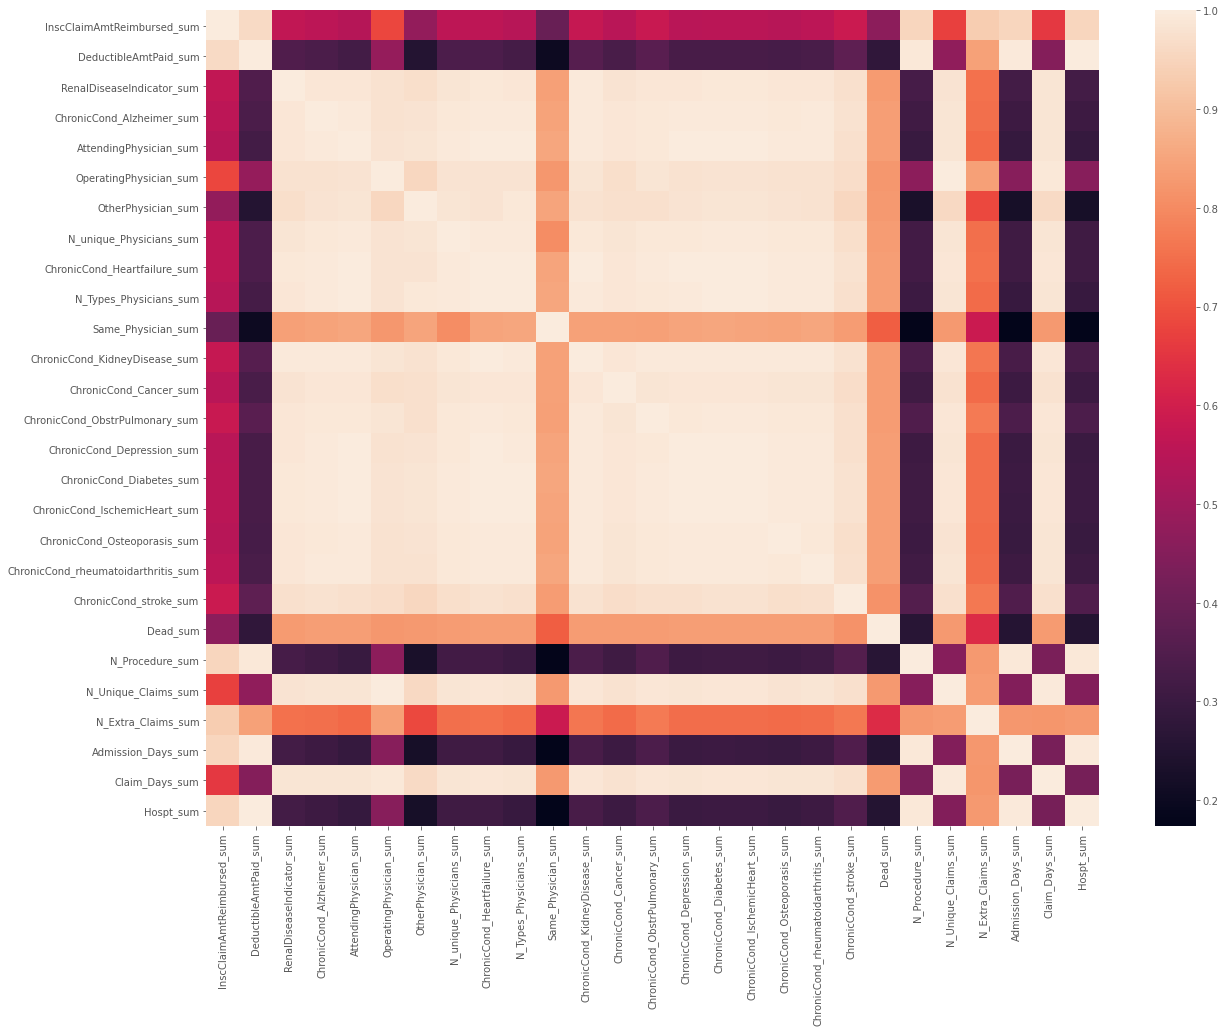

In [152]:
plot_corr(_sum)

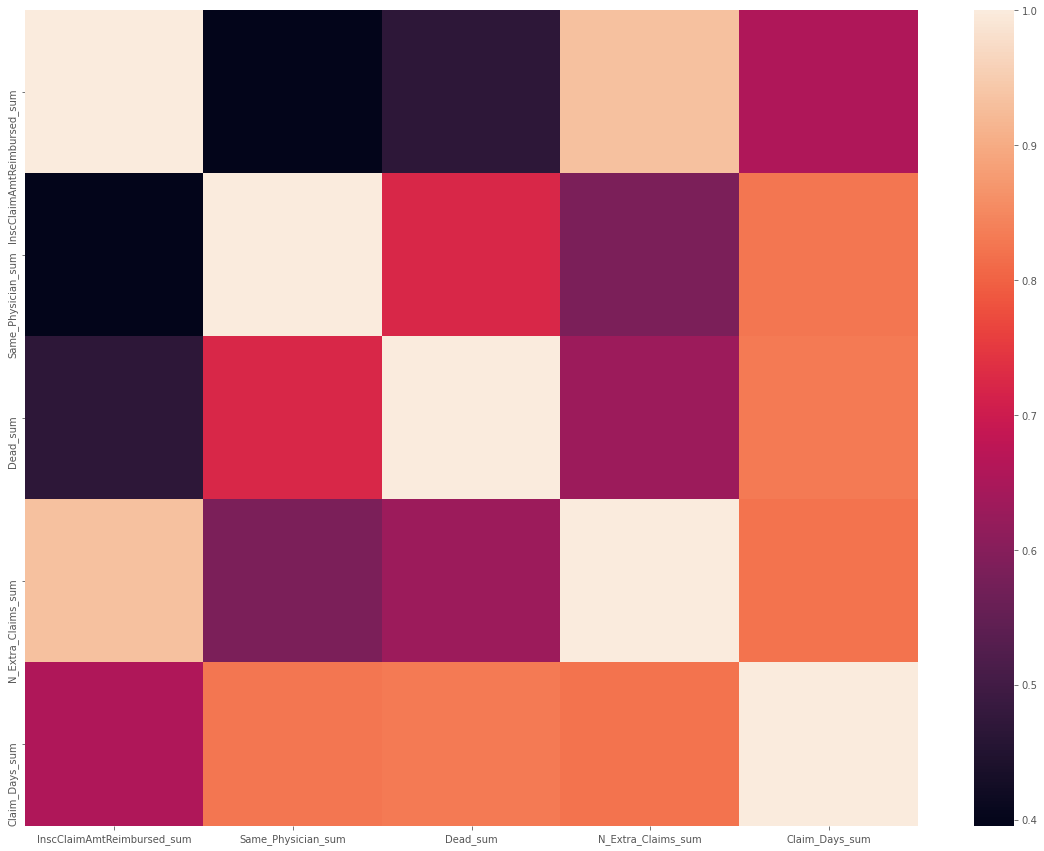

In [153]:
sum_corr = _sum.drop(['Hospt_sum','AttendingPhysician_sum','OperatingPhysician_sum','Admission_Days_sum',
                      'OtherPhysician_sum','ChronicCond_ObstrPulmonary_sum', 'ChronicCond_Depression_sum',
                      'ChronicCond_Diabetes_sum','ChronicCond_IschemicHeart_sum','ChronicCond_KidneyDisease_sum', 
                      'ChronicCond_Cancer_sum','ChronicCond_Osteoporasis_sum','RenalDiseaseIndicator_sum',
                      'ChronicCond_rheumatoidarthritis_sum','ChronicCond_Heartfailure_sum','N_Unique_Claims_sum',
                      'ChronicCond_Alzheimer_sum','ChronicCond_stroke_sum','N_Procedure_sum','N_unique_Physicians_sum',
                      'N_Types_Physicians_sum','DeductibleAmtPaid_sum'],axis=1) 


plot_corr(sum_corr)

- Hosp and admision days, N_Procedure have a strong correlation with DeductibleAmtPaid, try a model only with DeductibleAmtPaid
- All physicians type variables except for same physicians, are correlated to medical variables

In [154]:
sum_corr = sum_corr.merge(target, left_on='Provider_sum', right_on='Provider', how='left')

model, X_train, X_test, y_train, y_test = fcatboost(sum_corr.drop(['Provider','target','Provider_sum'], axis = 1),
                                                    sum_corr.target)

0.9234235477709057 {'depth': 3, 'iterations': 250, 'learning_rate': 0.03, 'l2_leaf_reg': 3, 'border_count': 5, 'thread_count': 4, 'random_seed': 2} best: 0.9234235476221115 {'depth': 3, 'iterations': 250, 'learning_rate': 0.03, 'l2_leaf_reg': 3, 'border_count': 5, 'thread_count': 4, 'random_seed': 2}
0.9281774876728406 {'depth': 3, 'iterations': 250, 'learning_rate': 0.03, 'l2_leaf_reg': 3, 'border_count': 10, 'thread_count': 4, 'random_seed': 2} best: 0.9281774878370613 {'depth': 3, 'iterations': 250, 'learning_rate': 0.03, 'l2_leaf_reg': 3, 'border_count': 10, 'thread_count': 4, 'random_seed': 2}
0.9310793735640622 {'depth': 3, 'iterations': 250, 'learning_rate': 0.03, 'l2_leaf_reg': 3, 'border_count': 20, 'thread_count': 4, 'random_seed': 2} best: 0.9310793735638939 {'depth': 3, 'iterations': 250, 'learning_rate': 0.03, 'l2_leaf_reg': 3, 'border_count': 20, 'thread_count': 4, 'random_seed': 2}
0.9300249408267071 {'depth': 3, 'iterations': 250, 'learning_rate': 0.03, 'l2_leaf_reg': 3


Shap features importance:


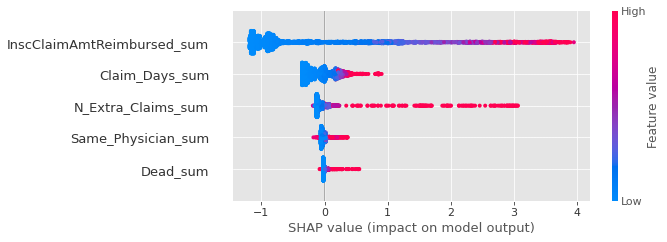


Recall Score: 0.5517241379310345


In [155]:
catboost_shap_plot(model, X_train, y_train)

recall_metric(model, X_test, y_test)

## Mean

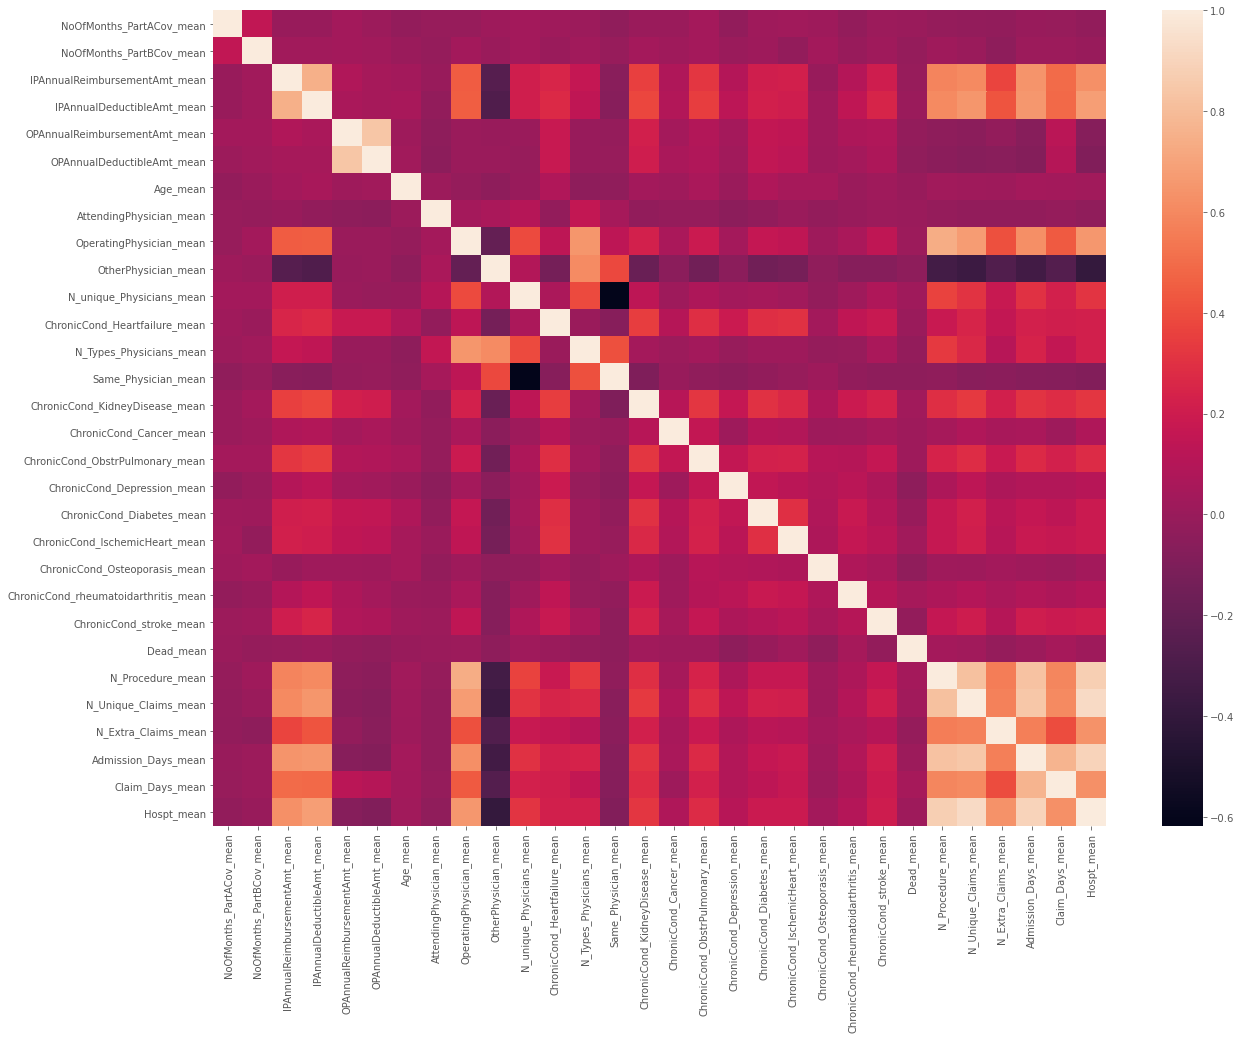

In [156]:
plot_corr(_mean)

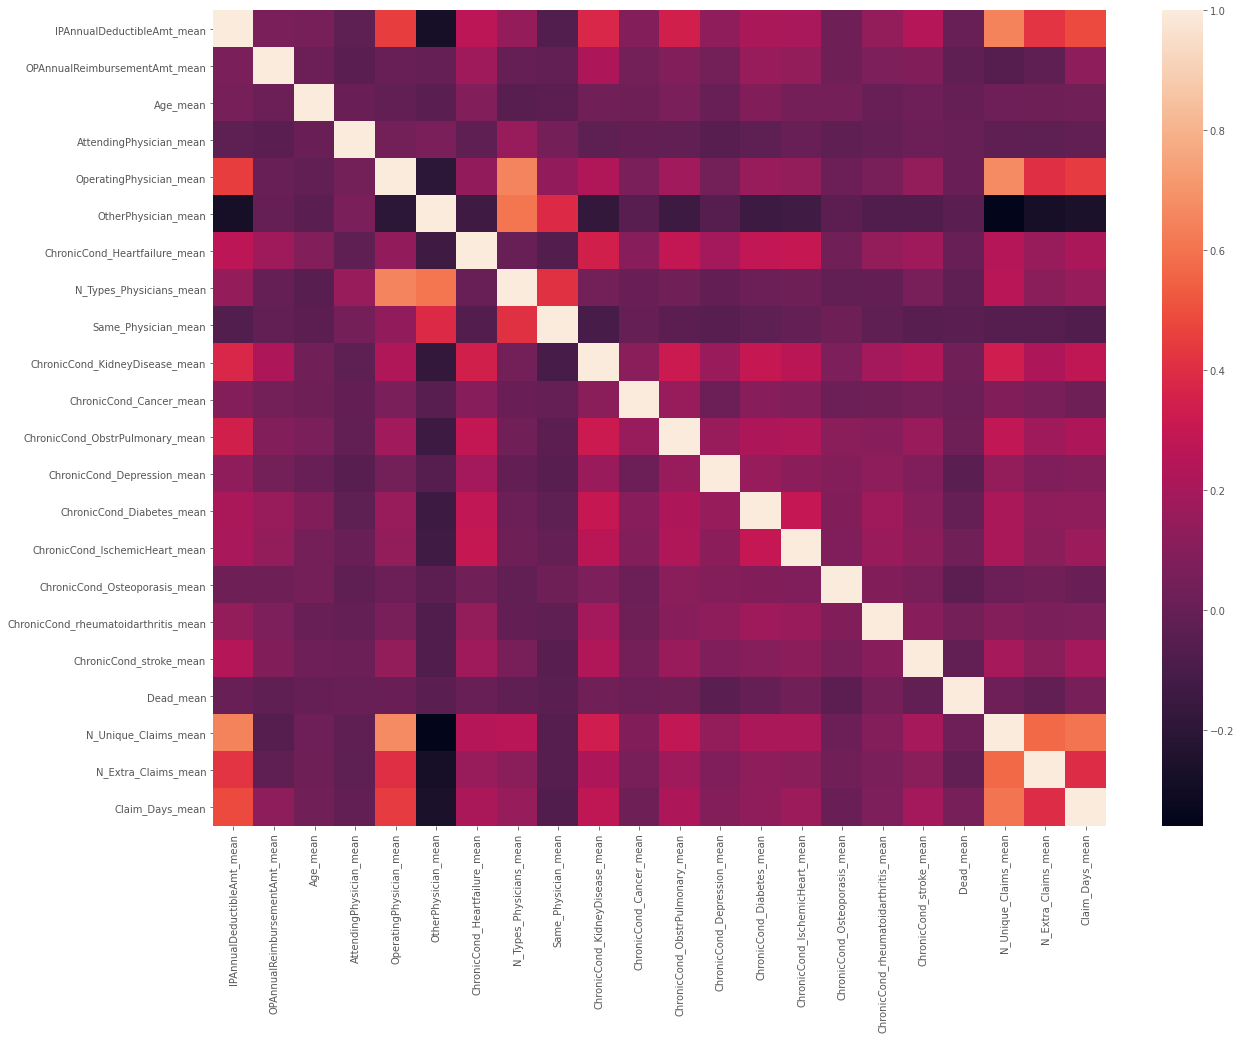

In [157]:
mean_corr = _mean.drop(['Hospt_mean','Admission_Days_mean','N_unique_Physicians_mean','NoOfMonths_PartBCov_mean',
                        'NoOfMonths_PartACov_mean','IPAnnualReimbursementAmt_mean','N_Procedure_mean',
                        'OPAnnualDeductibleAmt_mean'], axis=1) 

plot_corr(mean_corr)

In [158]:
mean_corr = mean_corr.merge(target, left_on='Provider_mean', right_on='Provider', how='left')

model, X_train, X_test, y_train, y_test = fcatboost(mean_corr.drop(['Provider','target','Provider_mean'], axis = 1),
                                                    mean_corr.target)

0.9184042220808504 {'depth': 3, 'iterations': 250, 'learning_rate': 0.03, 'l2_leaf_reg': 3, 'border_count': 5, 'thread_count': 4, 'random_seed': 2} best: 0.918404222005465 {'depth': 3, 'iterations': 250, 'learning_rate': 0.03, 'l2_leaf_reg': 3, 'border_count': 5, 'thread_count': 4, 'random_seed': 2}
0.9141795898461599 {'depth': 3, 'iterations': 250, 'learning_rate': 0.03, 'l2_leaf_reg': 3, 'border_count': 10, 'thread_count': 4, 'random_seed': 2} best: 0.918404222005465 {'depth': 3, 'iterations': 250, 'learning_rate': 0.03, 'l2_leaf_reg': 3, 'border_count': 5, 'thread_count': 4, 'random_seed': 2}
0.9173491619539255 {'depth': 3, 'iterations': 250, 'learning_rate': 0.03, 'l2_leaf_reg': 3, 'border_count': 20, 'thread_count': 4, 'random_seed': 2} best: 0.918404222005465 {'depth': 3, 'iterations': 250, 'learning_rate': 0.03, 'l2_leaf_reg': 3, 'border_count': 5, 'thread_count': 4, 'random_seed': 2}
0.9189293471509612 {'depth': 3, 'iterations': 250, 'learning_rate': 0.03, 'l2_leaf_reg': 3, 'bo


Shap features importance:


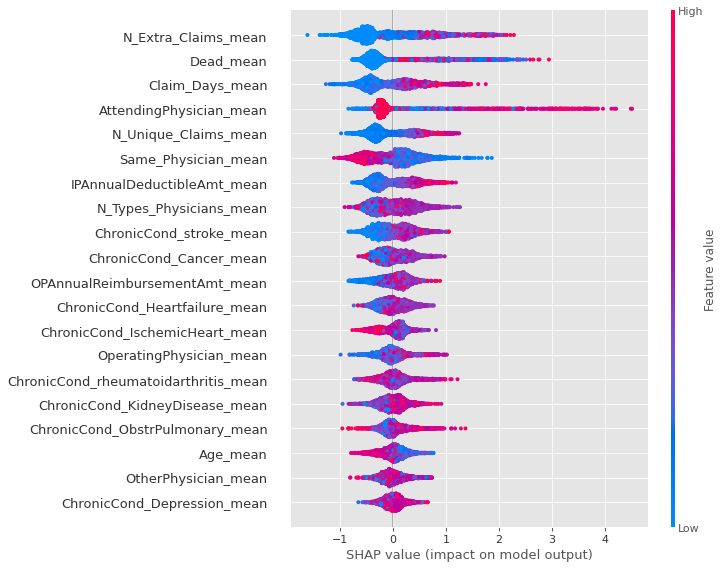


Recall Score: 0.2482758620689655


In [159]:
catboost_shap_plot(model, X_train, y_train)

recall_metric(model, X_test, y_test)

# Select Feature
Based on the previous shap plot, we now have the 

In [175]:
df = _total[['N_Extra_Claims_sum','InscClaimAmtReimbursed_sum',
             'N_Extra_Claims_mean','Dead_mean','AttendingPhysician_mean','N_Unique_Claims_mean',#'Same_Physician2_mean',
             'BeneID_count','ClaimID_count',
             'Provider','target']]

## Catboost

In [173]:
from sklearn.model_selection import StratifiedKFold

In [189]:
df = _total[['N_Extra_Claims_sum','InscClaimAmtReimbursed_sum',
             'N_Extra_Claims_mean','Dead_mean','AttendingPhysician_mean','N_Unique_Claims_mean',#'Same_Physician2_mean',
             'BeneID_count','ClaimID_count',
             'Provider','target']]
    
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=1)
target = df.target
df = df.drop(['Provider','target'], axis = 1)
    
for train_index, test_index in skf.split(df, target):
    #print("TRAIN:", train_index, "TEST:", test_index)
    
    X_train = df.iloc[train_index]
    X_test = pd.DataFrame(target[train_index])
    y_train = df.iloc[test_index]
    y_test = target[test_index]
#print(X_train.head())
print(X_test.columns)

Index(['target'], dtype='object')


In [161]:
model, X_train, X_test, y_train, y_test = fcatboost(df.drop(['Provider','target'], axis = 1),
                                                    df.target)

0.9247410658679579 {'depth': 3, 'iterations': 250, 'learning_rate': 0.03, 'l2_leaf_reg': 3, 'border_count': 5, 'thread_count': 4, 'random_seed': 2} best: 0.9247410659506012 {'depth': 3, 'iterations': 250, 'learning_rate': 0.03, 'l2_leaf_reg': 3, 'border_count': 5, 'thread_count': 4, 'random_seed': 2}
0.9265931198786713 {'depth': 3, 'iterations': 250, 'learning_rate': 0.03, 'l2_leaf_reg': 3, 'border_count': 10, 'thread_count': 4, 'random_seed': 2} best: 0.9265931198441065 {'depth': 3, 'iterations': 250, 'learning_rate': 0.03, 'l2_leaf_reg': 3, 'border_count': 10, 'thread_count': 4, 'random_seed': 2}
0.9287049131713748 {'depth': 3, 'iterations': 250, 'learning_rate': 0.03, 'l2_leaf_reg': 3, 'border_count': 20, 'thread_count': 4, 'random_seed': 2} best: 0.9287049131240853 {'depth': 3, 'iterations': 250, 'learning_rate': 0.03, 'l2_leaf_reg': 3, 'border_count': 20, 'thread_count': 4, 'random_seed': 2}
0.9326652052672282 {'depth': 3, 'iterations': 250, 'learning_rate': 0.03, 'l2_leaf_reg': 3


Shap features importance:


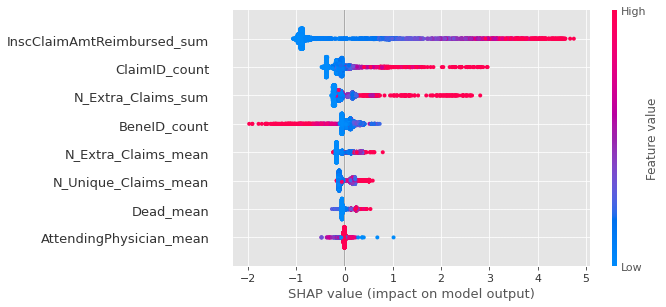


ROC curve:


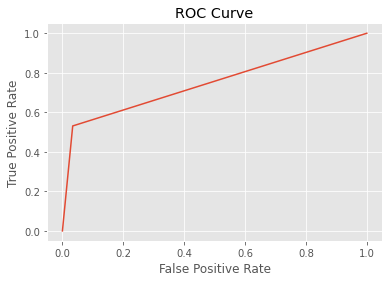

AUC of ROC Curve: 0.7486024917176053

Confusion Table:
[[1428   50]
 [  68   77]]
Accuracy Score: 0.9272951324707333

Recall Score: 0.5310344827586206


In [162]:
catboost_shap_plot(model, X_train, y_train)

metrics_score(model, X_test, y_test)

## Logistic Regression

In [163]:
def flogistic(df, penalty):
    X_train, X_test, y_train, y_test = train_test_split(df.drop(['Provider','target'], axis = 1),df.target, 
                                                  test_size=0.30, random_state=1)

    X_train = pd.DataFrame(StandardScaler().fit_transform(X_train))
    X_test = pd.DataFrame(StandardScaler().fit_transform(X_test))
    
    clf = LogisticRegression(penalty= penalty,solver= 'liblinear',class_weight='balanced', random_state = 5 , C = 0.001).\
                        fit(X_train,y_train)

    #Liblinear for small datasets binary classes

    preds = clf.predict(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, preds)
    roc_auc = roc_auc_score(y_test, preds)
    
    plt.plot(fpr, tpr)
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    print('\nROC curve:')
      
    plt.show()
    print('AUC of ROC Curve: {}'.format(roc_auc))
    print('\nConfusion Table:')

    print(confusion_matrix(y_test, preds))
    print('Recall Score: {}'.format(recall_score(y_test, preds)))
    print('Accuracy Score: {}'.format(accuracy_score(y_test, preds)))
    


ROC curve:


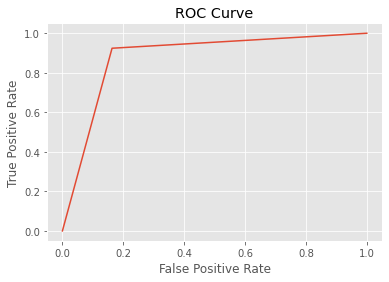

AUC of ROC Curve: 0.8805398721478233

Confusion Table:
[[1237  241]
 [  11  134]]
Recall Score: 0.9241379310344827
Accuracy Score: 0.844731977818854


In [164]:
flogistic(df, 'l1')


ROC curve:


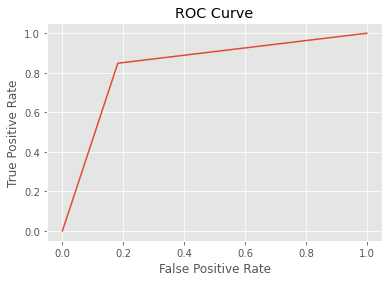

AUC of ROC Curve: 0.8331365778545099

Confusion Table:
[[1209  269]
 [  22  123]]
Recall Score: 0.8482758620689655
Accuracy Score: 0.8207024029574861


In [165]:
flogistic(df, 'l2')

## Naive Bayes

In [166]:
def Gaus_bayes(df):
    X_train, X_test, y_train, y_test = train_test_split(df.drop(['Provider','target'], axis = 1),df.target, 
                                                  test_size=0.30, random_state=1)


    X_train = pd.DataFrame(StandardScaler().fit_transform(X_train))
    X_test = pd.DataFrame(StandardScaler().fit_transform(X_test))

    gnb = GaussianNB()
    preds = gnb.fit(X_train, y_train).predict(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, preds)
    roc_auc = roc_auc_score(y_test, preds)
    
    plt.plot(fpr, tpr)
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    print('\nROC curve:')
      
    plt.show()
    print('AUC of ROC Curve: {}'.format(roc_auc))
    print('\nConfusion Table:')

    print(confusion_matrix(y_test, preds))
    print('Recall Score: {}'.format(recall_score(y_test, preds)))
    print('Accuracy Score: {}'.format(accuracy_score(y_test, preds)))


ROC curve:


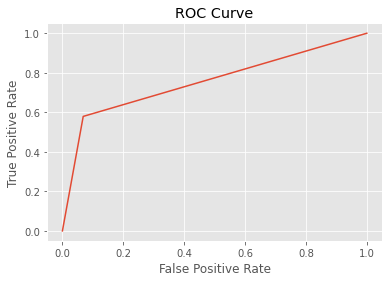

AUC of ROC Curve: 0.7554873780971489

Confusion Table:
[[1377  101]
 [  61   84]]
Recall Score: 0.5793103448275863
Accuracy Score: 0.9001848428835489


In [167]:
Gaus_bayes(df)